# Terrain Classification - Compare Window Size

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import sklearn
import numpy as np

#### Data Structure

`Dictionary of Feature Vectors
-> Dictionary of Placements
---> Dictionary of Window Sizes
-----> Dataframe of Processed Data`

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [3]:
# Initialize data structure of imported data
sizes = {size: () for size in [50, 100, 200, 300, 400, 500]}
vectors = {vector: sizes for vector in ['Features', 'FFTs', 'PSDLogs']}
placements = {placement: vectors for placement in ['Left', 'Middle', 'Right']}

# For each .csv of processed data
for filename in glob.glob('processed_data/windows/*.csv'):
    _placement, _vector, _size = filename.split('/')[-1].split('.')[0].split('_')
    data = pd.read_csv(filename)
    labels = data.pop('Label')
    
    # Save as tuple of data and labels
    placements[_placement][_vector][int(_size)] = (data, labels)

In [59]:
'''Run n-fold classifier training and testing on all placements, feature vectors, window sizes'''
def classify_sizes(cv_value=5):
    # Metric classifier dictionary
    _classifiers = {}
    
    for classifier_name, classifier in classifiers.items():
        # Update classifier model
        model = classifiers[classifier_name]
        
        # Go through each placement/vector/size
        _placements = {}
        for placement_name, placement in placements.items():
            _vectors = {}
            for vector_name, vector in placement.items():
                _sizes = {}
                for size_value, (size_data, size_labels) in vector.items():
                    # Get preferred metric through mean of five cross validations
                    # Metrics = 'fit_time', 'score_time', 'test_score', 'train_score'
                    metrics = cross_validate(model, size_data, size_labels, cv=cv_value, 
                                                    return_train_score=True)
                    _sizes.update({size_value: metrics})
                
                _vectors.update({vector_name: _sizes})
            
            _placements.update({placement_name: _vectors})
        
        _classifiers.update({classifier_name: _placements})
    
    return _classifiers

In [5]:
classifier_metrics = classify_sizes()

In [73]:
'''Plot given metric vs window size for given placement, feature vector, and classifiers'''
def plot_sizes(classifier_names, placement_names, vector_names, metric, cv_value=5):
    # Figure setup
    fig = plt.subplots(figsize=(10, 8))
    plt.title('Window Size Comparision of ' + metric.replace('_', ' ').capitalize())
    plt.xlabel('Window Size')
    
    # Go through each of the given classifiers/placements/vectors
    for classifier in classifier_names:
        for placement in placement_names:
            for vector in vector_names:
        
                # Retrieve size data of given classifier placement and vector
                sizes = classifier_metrics[classifier][placement][vector]
                plot_data = []

                if metric == 'test_score' or metric == 'train_score':
                    plt.ylabel('Score (%)')
                    #plt.ylim(0, 1.0)
                    
                    # Plot mean of metric over multi fold testing
                    for metrics in sizes.values():
                        plot_data.append(np.mean(metrics[metric]))

                elif metric == 'fit_time' or metric == 'score_time':
                    plt.ylabel('Time (s)')
                    
                    # Plot mean of metric over multi fold testing scaled by number of windows tested/trained
                    n_windows = len(placements[placement][vector][50][1])
                    if metric == 'fit_time':
                        n_windows *= (cv_value - 1) / cv_value
                    elif metric == 'score_time':
                        n_windows *= 1 / cv_value
                    for metrics in sizes.values():
                        plot_data.append(np.mean(metrics[metric]) / n_windows)
                
                # Plot window size vs plot data
                plt.plot(list(sizes.keys()), plot_data, label=classifier + ' ' + placement + ' ' + vector)
    
    plt.legend()
    plt.show()

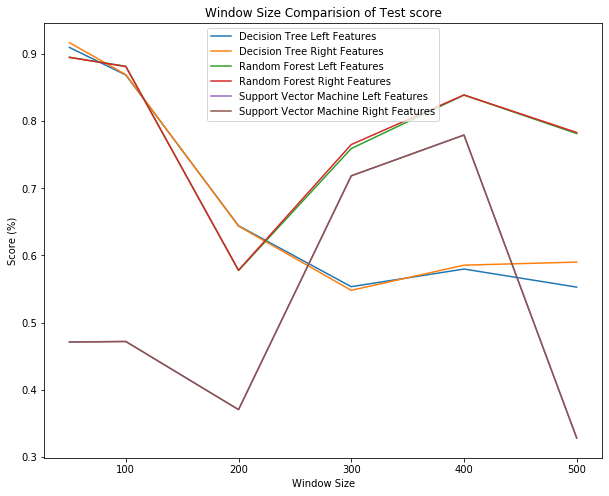

In [74]:
plot_sizes(classifier_names=['Decision Tree', 'Random Forest', 'Support Vector Machine'],
           placement_names=['Left', 'Right'], vector_names=['Features'], 
           metric='test_score')

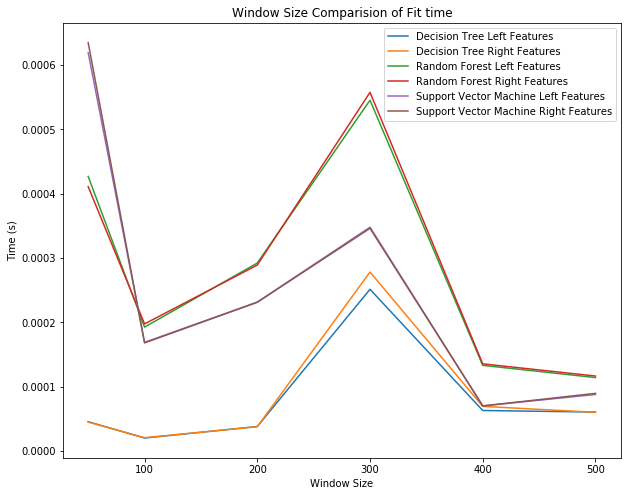

In [76]:
plot_sizes(classifier_names=['Decision Tree', 'Random Forest', 'Support Vector Machine'],
           placement_names=['Left', 'Right'], vector_names=['Features'], 
           metric='fit_time')